In [1]:
#! pip -q install pandas matplotlib
#! pip install -q scikit-learn
#! pip install -q joblib
#! pip install -q tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import joblib


pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [3]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [4]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'holiday_name', 'shutdown', 'snow', 'shops_closed', 'mov_change', 'date', 'blackout', 'frankfurt_shutdown', 'warehouse', 'mini_shutdown', 'winter_school_holidays', 'holiday', 'precipitation', 'school_holidays'}
No differences found in column: holiday_name
No differences found in column: shutdown
No differences found in column: snow
No differences found in column: shops_closed
No differences found in column: mov_change
No differences found in column: blackout
No differences found in column: frankfurt_shutdown
No differences found in column: mini_shutdown
No differences found in column: winter_school_holidays
No differences found in column: holiday
No differences found in column: precipitation
No differences found in column: school_holidays

Success. All values match across the datasets, datasets merged.
{'holiday_name', 'shops_closed', 'date', 'warehouse', 'winter_school_holidays', 'holiday', 'school_holidays'}
No differences found in column: holiday_name
No differences found in column

In [5]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [6]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['shutdown', 'snow', 'mov_change', 'user_activity_2', 'blackout', 'frankfurt_shutdown', 'user_activity_1', 'warehouse_limited', 'precipitation', 'mini_shutdown']


In [7]:
train_df = train_df.drop(columns=unavailable_features)

In [8]:
# list redundant columns that have unchanging values
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [9]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [10]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [11]:
test_df.head()

warehouse       date holiday_name  holiday  shops_closed  \
61        Brno_1 2024-03-16          NaN        0             0   
340   Budapest_1 2024-03-16          NaN        0             0   
292  Frankfurt_1 2024-03-16          NaN        0             0   
244     Munich_1 2024-03-16          NaN        0             0   
0       Prague_1 2024-03-16          NaN        0             0   

     winter_school_holidays  school_holidays                      id  
61                        0                0       Brno_1_2024-03-16  
340                       0                0   Budapest_1_2024-03-16  
292                       0                0  Frankfurt_1_2024-03-16  
244                       0                0     Munich_1_2024-03-16  
0                         0                0     Prague_1_2024-03-16

In [12]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [13]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [14]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [15]:
train_df.head(10)

warehouse       date  orders holiday_name  holiday  shops_closed  \
1193      Brno_1 2020-12-05  6447.0          NaN        0             0   
6186  Budapest_1 2020-12-05  4623.0          NaN        0             0   
0       Prague_1 2020-12-05  6895.0          NaN        0             0   
2386    Prague_2 2020-12-05  4154.0          NaN        0             0   
3579    Prague_3 2020-12-05  4091.0          NaN        0             0   
1194      Brno_1 2020-12-06  5338.0          NaN        0             0   
6187  Budapest_1 2020-12-06  4197.0          NaN        0             0   
1       Prague_1 2020-12-06  6584.0          NaN        0             0   
2387    Prague_2 2020-12-06  4016.0          NaN        0             0   
3580    Prague_3 2020-12-06  3972.0          NaN        0             0   

      winter_school_holidays  school_holidays                     id  
1193                       0                0      Brno_1_2020-12-05  
6186                       0                0  Budapest_1_2020-12-05  
0                          0                0    Prague_1_2020-12-05  
2386                       0                0    Prague_2_2020-12-05  
3579                       0                0    Prague_3_2020-12-05  
1194                       0                0      Brno_1_2020-12-06  
6187                       0                0  Budapest_1_2020-12-06  
1                          0                0    Prague_1_2020-12-06  
2387                       0                0    Prague_2_2020-12-06  
3580                       0                0    Prague_3_2020-12-06

In [16]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['days_since_start'] = (df.index - df.index.min()).days
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    #df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    #df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    time_features = ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos']
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    binary_features = ['is_weekend']
    return df, time_features, categorical_features, binary_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [17]:
train_df, time_features, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

In [18]:
train_df = train_df.drop(columns=['holiday_name']) 

### Plot

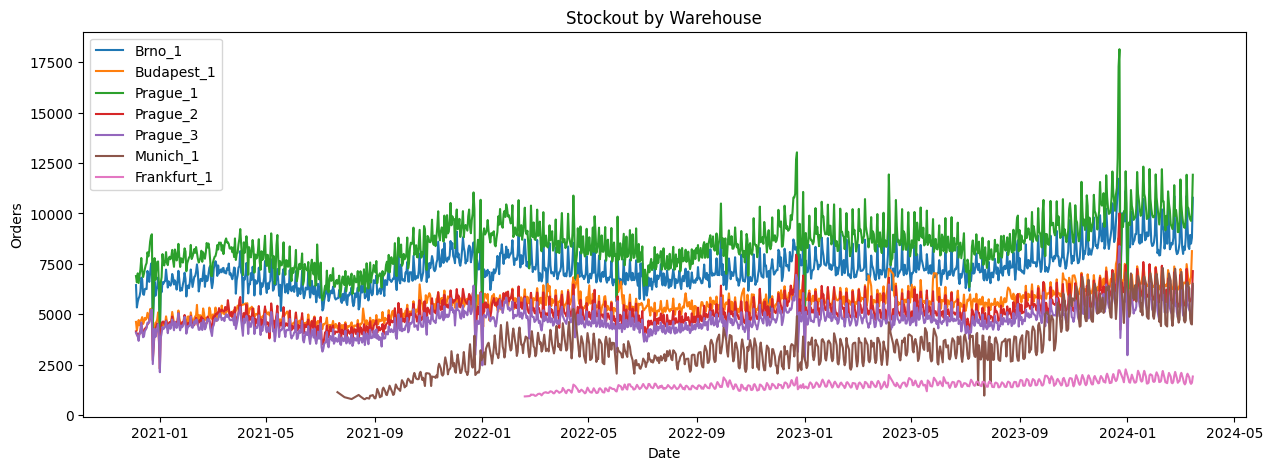

In [19]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

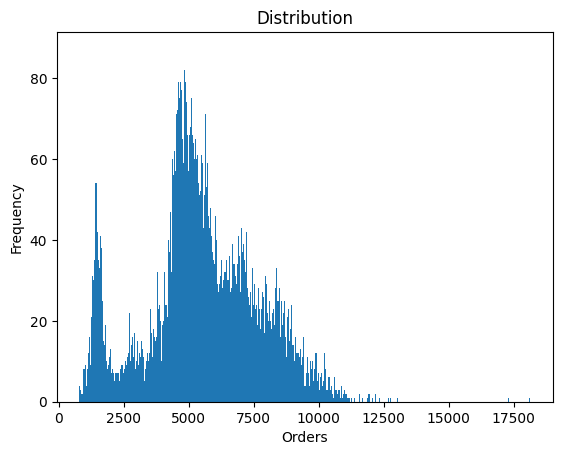

In [20]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

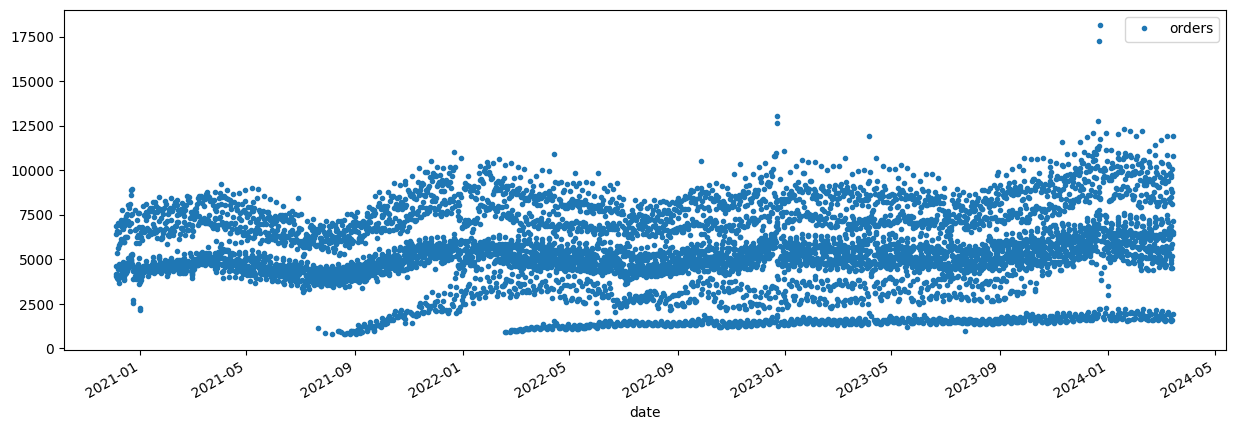

In [21]:
train_df.query('orders > 500').plot(y='orders', figsize=(15, 5), style='.')

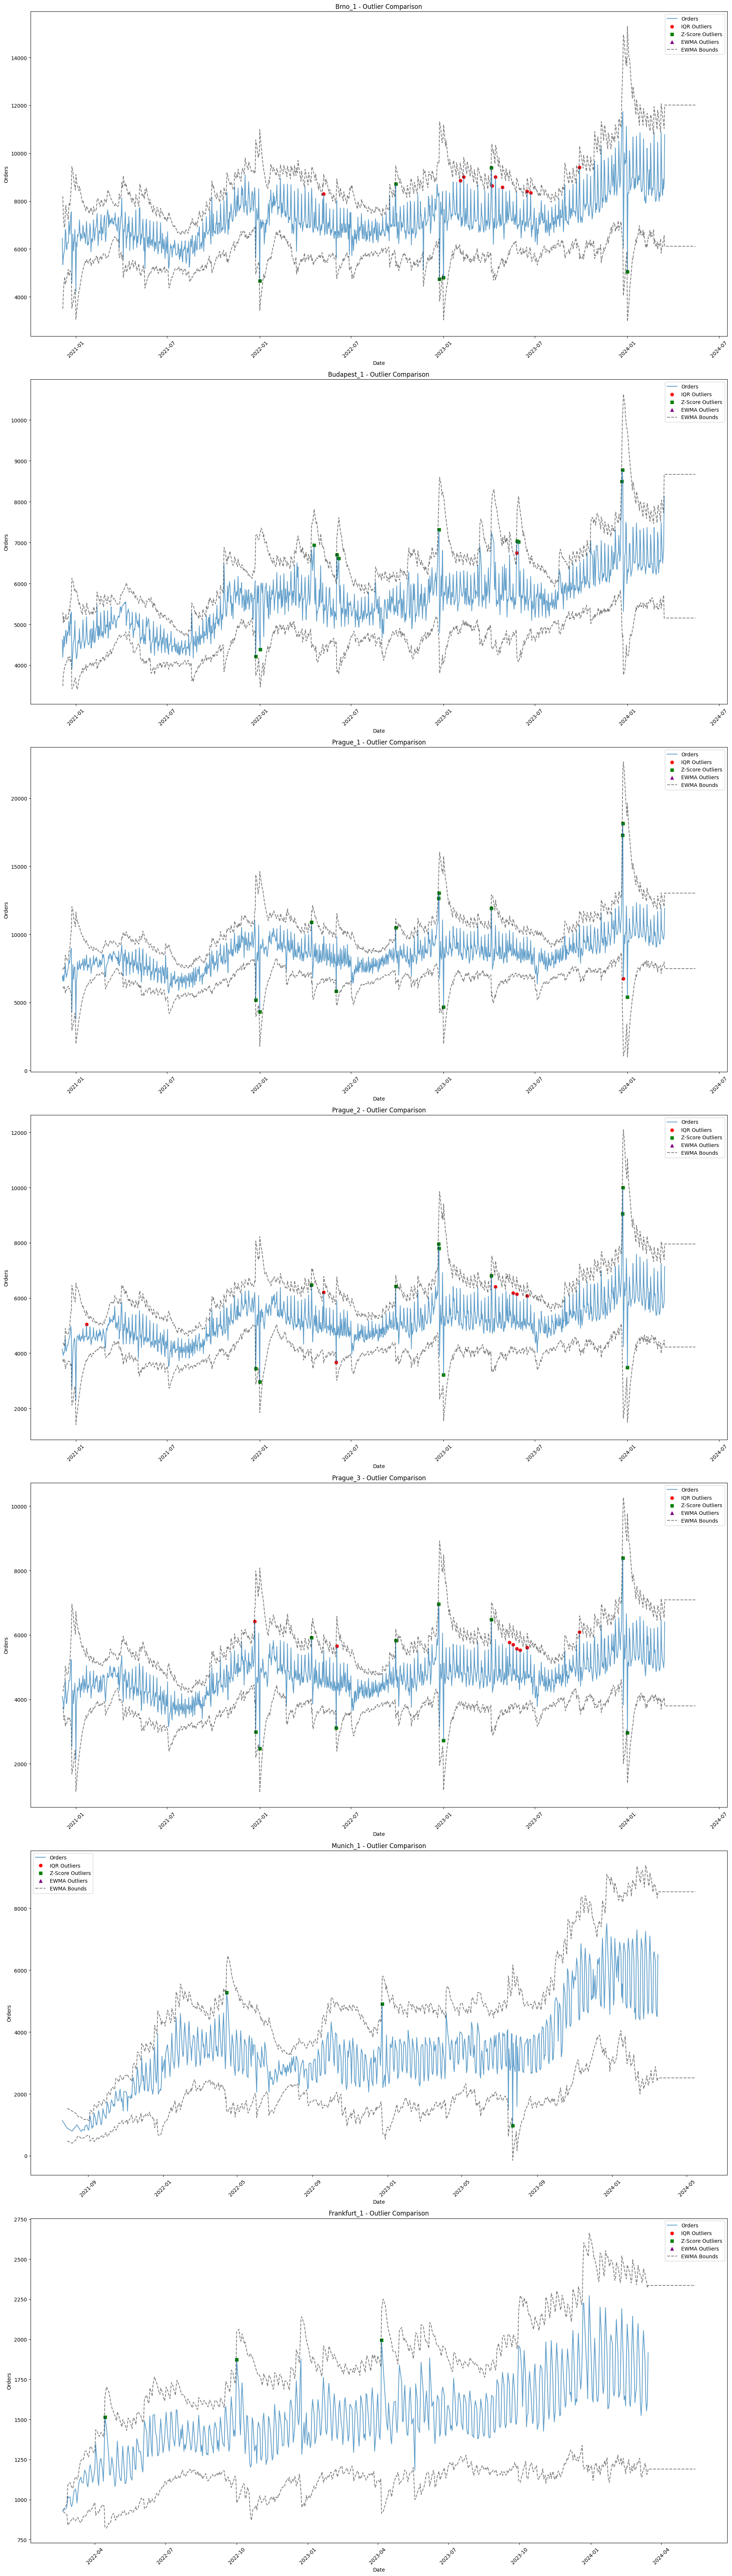


Brno_1:
IQR Outliers: 15
Z-Score Outliers: 6
EWMA Outliers: 0

Budapest_1:
IQR Outliers: 8
Z-Score Outliers: 10
EWMA Outliers: 0

Prague_1:
IQR Outliers: 13
Z-Score Outliers: 12
EWMA Outliers: 0

Prague_2:
IQR Outliers: 18
Z-Score Outliers: 11
EWMA Outliers: 0

Prague_3:
IQR Outliers: 18
Z-Score Outliers: 10
EWMA Outliers: 0

Munich_1:
IQR Outliers: 0
Z-Score Outliers: 3
EWMA Outliers: 0

Frankfurt_1:
IQR Outliers: 1
Z-Score Outliers: 3
EWMA Outliers: 0


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def adaptive_iqr_outlier_detection(data, window=14, iqr_multiplier=1.5):
    data = data.sort_index()
    rolling_q1 = data.rolling(window=window, center=True).quantile(0.25)
    rolling_q3 = data.rolling(window=window, center=True).quantile(0.75)
    rolling_iqr = rolling_q3 - rolling_q1
    lower_bound = rolling_q1 - (iqr_multiplier * rolling_iqr)
    upper_bound = rolling_q3 + (iqr_multiplier * rolling_iqr)
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

def z_score_outlier_detection(data, window=14, threshold=3):
    data = data.sort_index()
    rolling_mean = data.rolling(window=window, center=True).mean()
    rolling_std = data.rolling(window=window, center=True).std()
    z_scores = (data - rolling_mean) / rolling_std
    outliers = np.abs(z_scores) > threshold
    return outliers

def ewma_outlier_detection(data, span=14, threshold=3):
    data = data.sort_index()
    ewma = data.ewm(span=span).mean()
    ewmstd = data.ewm(span=span).std()
    lower_bound = ewma - (threshold * ewmstd)
    upper_bound = ewma + (threshold * ewmstd)
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound

def plot_outlier_comparison(train_df, window=28, iqr_multiplier=2.8, z_threshold=3, ewma_span=14, ewma_threshold=3):
    warehouses = train_df['warehouse'].unique()
    n_warehouses = len(warehouses)
    
    n_cols = 1
    n_rows = n_warehouses
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10*n_rows))
    axes = axes.flatten() if n_warehouses > 1 else [axes]
    
    for idx, warehouse in enumerate(warehouses):
        warehouse_data = train_df[train_df.warehouse == warehouse]['orders']
        
        iqr_outliers = adaptive_iqr_outlier_detection(warehouse_data, window, iqr_multiplier)
        z_outliers = z_score_outlier_detection(warehouse_data, window, z_threshold)
        ewma_outliers, lower_bound, upper_bound = ewma_outlier_detection(warehouse_data, ewma_span, ewma_threshold)
        
        ax = axes[idx]
        ax.plot(warehouse_data.index, warehouse_data, label='Orders', alpha=0.7)
        ax.scatter(warehouse_data.index[iqr_outliers], warehouse_data[iqr_outliers], color='red', label='IQR Outliers', marker='o')
        ax.scatter(warehouse_data.index[z_outliers], warehouse_data[z_outliers], color='green', label='Z-Score Outliers', marker='s')
        ax.scatter(warehouse_data.index[ewma_outliers], warehouse_data[ewma_outliers], color='purple', label='EWMA Outliers', marker='^')
        ax.plot(warehouse_data.index, lower_bound, 'k--', label='EWMA Bounds', alpha=0.5)
        ax.plot(warehouse_data.index, upper_bound, 'k--', alpha=0.5)
        
        ax.set_title(f'{warehouse} - Outlier Comparison')
        ax.set_xlabel('Date')
        ax.set_ylabel('Orders')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of outliers for each warehouse
    for warehouse in warehouses:
        warehouse_data = train_df[train_df.warehouse == warehouse]['orders']
        iqr_outliers = adaptive_iqr_outlier_detection(warehouse_data, window, iqr_multiplier)
        z_outliers = z_score_outlier_detection(warehouse_data, window, z_threshold)
        ewma_outliers, _, _ = ewma_outlier_detection(warehouse_data, ewma_span, ewma_threshold)
        
        print(f"\n{warehouse}:")
        print(f"IQR Outliers: {sum(iqr_outliers)}")
        print(f"Z-Score Outliers: {sum(z_outliers)}")
        print(f"EWMA Outliers: {sum(ewma_outliers)}")
    
    return iqr_outliers, z_outliers, ewma_outliers

# Call the function to plot all warehouses
iqr_outliers, z_outliers, ewma_outliers = plot_outlier_comparison(train_df, window=68, iqr_multiplier=2.5, z_threshold=3, ewma_span=14, ewma_threshold=3)

In [23]:
# Drop outliers
#train_df = train_df.drop(iqr_outliers.index)

# Do not drop outliers but fix their values to be average

#train_df.loc[z_outliers.index, 'orders'] = train_df['orders'].mean()
#train_df.loc[iqr_outliers.index, 'orders'] = train_df['orders'].mean()
#train_df.loc[ewma_outliers.index, 'orders'] = train_df['orders'].mean()

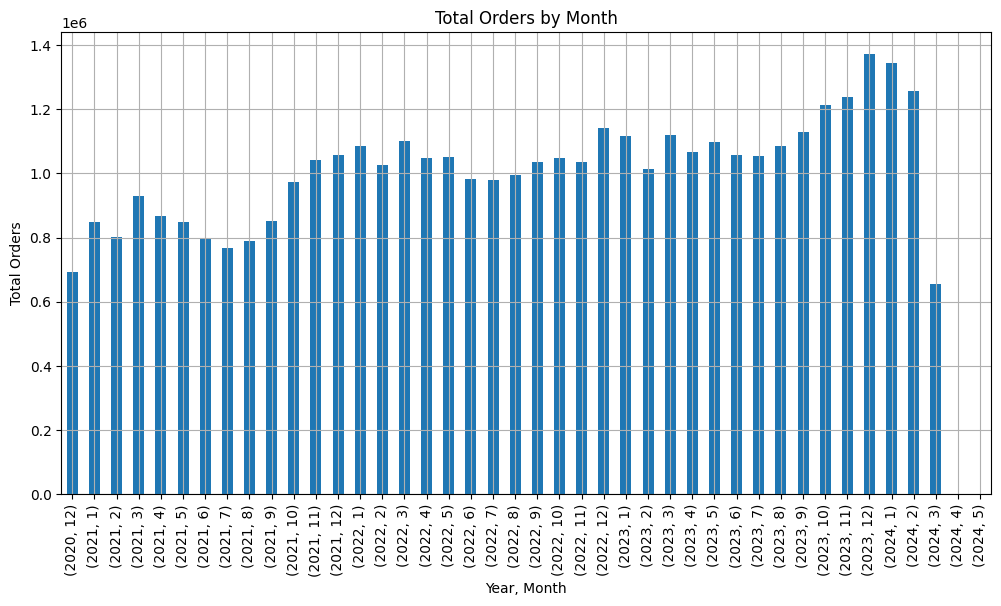

In [24]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

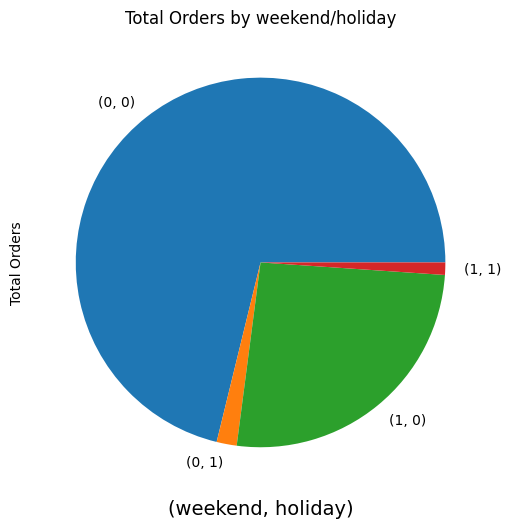

In [25]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [26]:
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

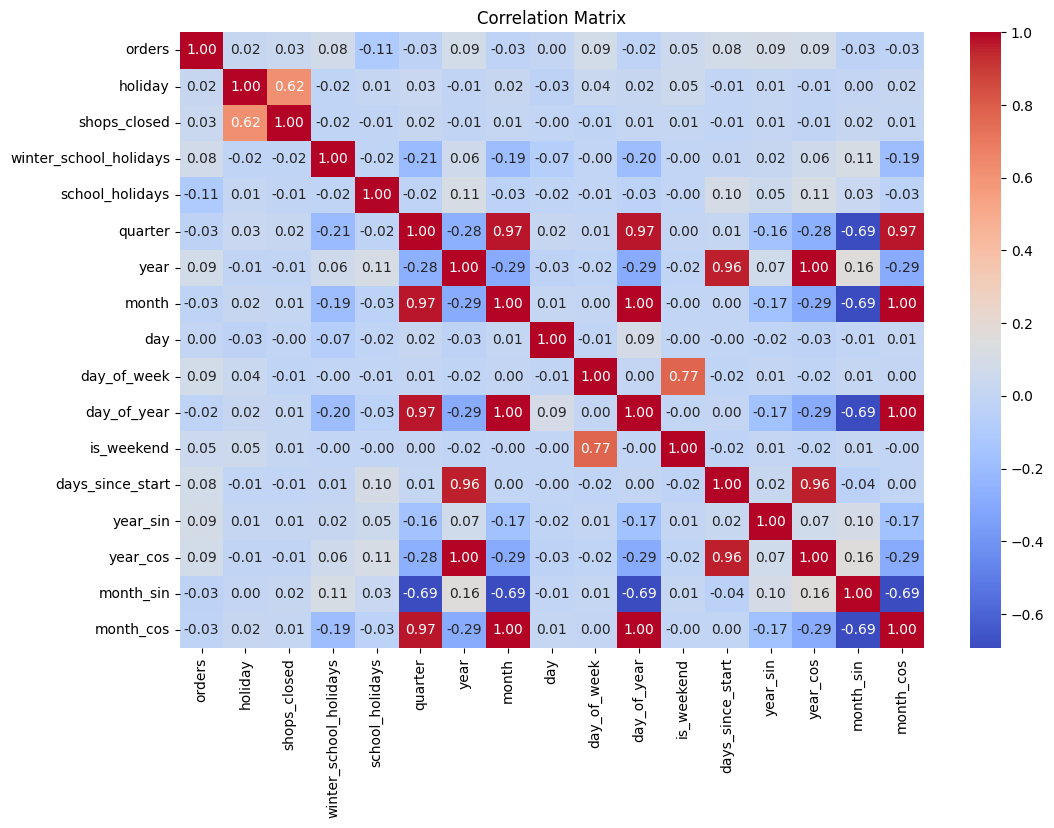

orders                    1.000000
year_sin                  0.087547
day_of_week               0.086522
year_cos                  0.085920
year                      0.085920
days_since_start          0.080793
winter_school_holidays    0.077211
is_weekend                0.046594
shops_closed              0.034824
holiday                   0.018006
day                       0.002689
day_of_year              -0.024332
month                    -0.025271
month_cos                -0.025271
month_sin                -0.029229
quarter                  -0.029323
school_holidays          -0.105071
Name: orders, dtype: float64


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Temporal features

In [28]:
LAG_DAYS = [7, 28, 56, 84, 168, 364]
ROLLING_WINDOW = [28, 168, 364]

In [29]:
def create_lag_features(df, col, lag_days):
    df = df.copy() 
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[std_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

In [30]:
train_df, lag_features = create_lag_features(train_df, 'orders', LAG_DAYS)
train_df, window_features = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

# Im putting my features into categories for better manipulation
numerical_features = ['orders']
numerical_features += lag_features + window_features
categorical_features=categorical_features

print(numerical_features)

train_df.head()

['orders', 'orders_lag_7', 'orders_lag_28', 'orders_lag_56', 'orders_lag_84', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


warehouse  orders  holiday  shops_closed  winter_school_holidays  \
date                                                                            
2020-12-05      Brno_1  6447.0        0             0                       0   
2020-12-05  Budapest_1  4623.0        0             0                       0   
2020-12-05    Prague_1  6895.0        0             0                       0   
2020-12-05    Prague_2  4154.0        0             0                       0   
2020-12-05    Prague_3  4091.0        0             0                       0   

            school_holidays                     id  quarter  year  month  day  \
date                                                                            
2020-12-05                0      Brno_1_2020-12-05        4  2020     12    5   
2020-12-05                0  Budapest_1_2020-12-05        4  2020     12    5   
2020-12-05                0    Prague_1_2020-12-05        4  2020     12    5   
2020-12-05                0    Prague_2_2020-12-05        4  2020     12    5   
2020-12-05                0    Prague_3_2020-12-05        4  2020     12    5   

            day_of_week  day_of_year  is_weekend  days_since_start  \
date                                                                 
2020-12-05            5          340           1                 0   
2020-12-05            5          340           1                 0   
2020-12-05            5          340           1                 0   
2020-12-05            5          340           1                 0   
2020-12-05            5          340           1                 0   

                year_sin  year_cos     month_sin  month_cos  orders_lag_7  \
date                                                                        
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   

            orders_lag_28  orders_lag_56  orders_lag_84  orders_lag_168  \
date                                                                      
2020-12-05            NaN            NaN            NaN             NaN   
2020-12-05            NaN            NaN            NaN             NaN   
2020-12-05            NaN            NaN            NaN             NaN   
2020-12-05            NaN            NaN            NaN             NaN   
2020-12-05            NaN            NaN            NaN             NaN   

            orders_lag_364  orders_rolling_mean_28  orders_rolling_std_28  \
date                                                                        
2020-12-05             NaN                  6447.0                    NaN   
2020-12-05             NaN                  4623.0                    NaN   
2020-12-05             NaN                  6895.0                    NaN   
2020-12-05             NaN                  4154.0                    NaN   
2020-12-05             NaN                  4091.0                    NaN   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                   6447.0                     NaN   
2020-12-05                   4623.0                     NaN   
2020-12-05                   6895.0                     NaN   
2020-12-05                   4154.0                     NaN   
2020-12-05                   4091.0                     NaN   

            orders_rolling_mean_364  orders_rolling_std_364  
date                                                         
2020-12-05                   6447.0                     NaN  
2020-12-05                   4623.0                     NaN  
2020-12-05                   6895.0                     NaN  
2020-12-05                  

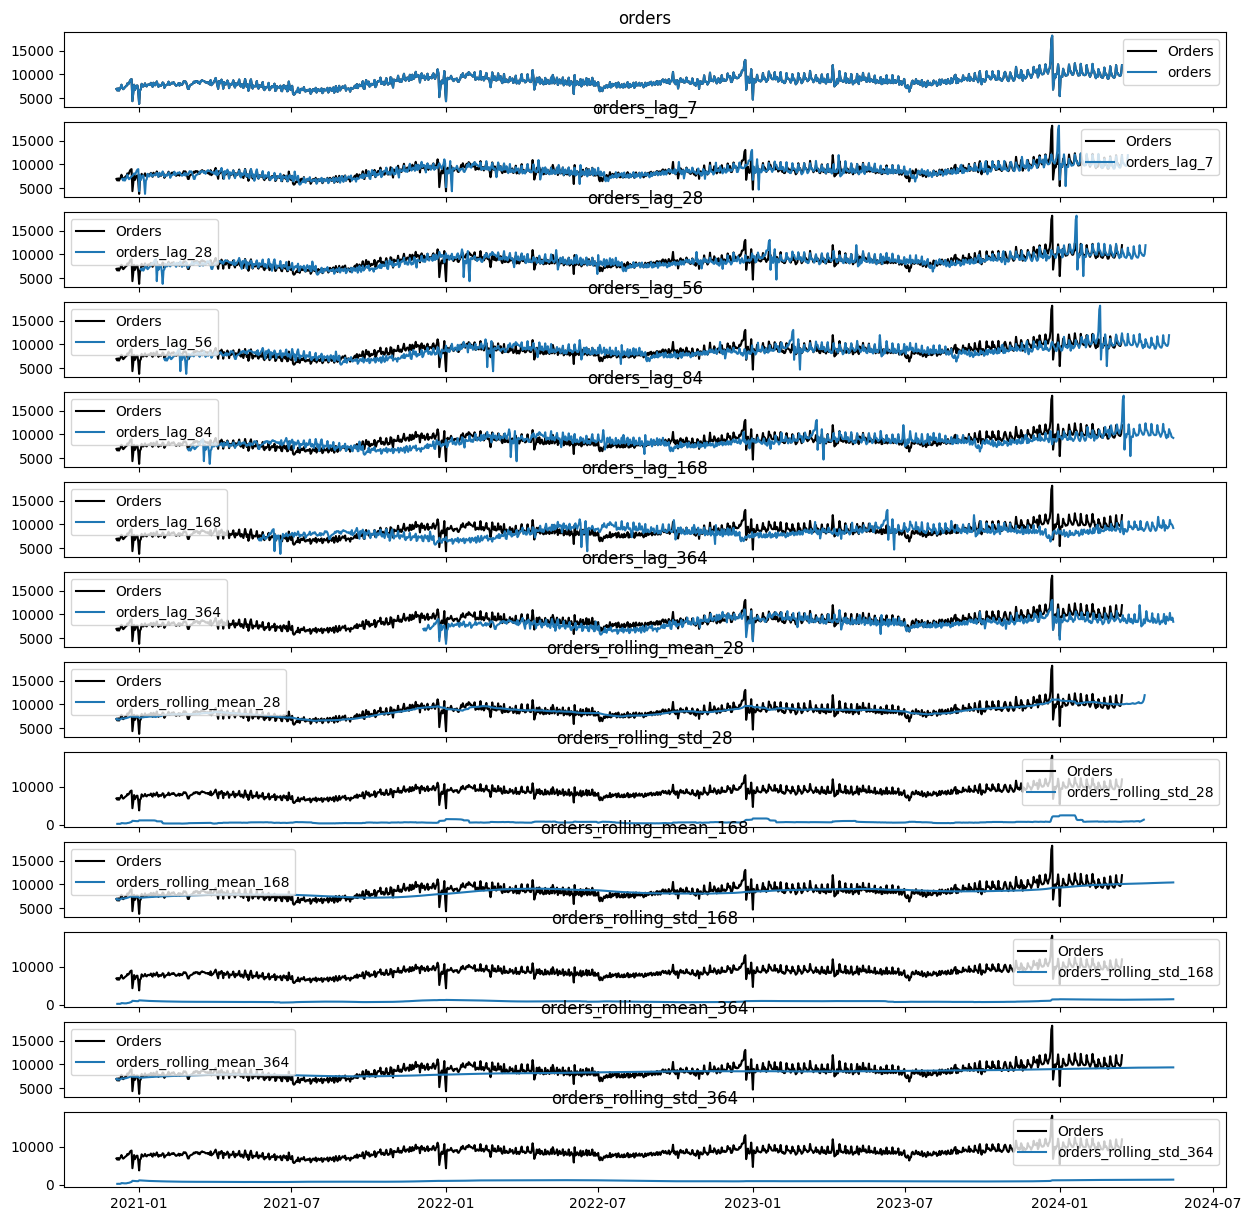

In [31]:
#orders and features above each other (for Prague_1)
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df[train_df.warehouse == 'Prague_1'].index, train_df[train_df.warehouse == 'Prague_1'].orders, label='Orders', color='black')
    ax[i].plot(train_df[train_df.warehouse == 'Prague_1'].index, train_df[train_df.warehouse == 'Prague_1'][feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


In [32]:
# divide dataset back into train and test datasets, for test set to export with new features and train to train on.
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
test_df["date"] = test_df.index
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

C:\Users\ondre\AppData\Local\Temp\ipykernel_13400\537004962.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["date"] = test_df.index


In [33]:
train_df.tail()

warehouse   orders  holiday  shops_closed  \
date                                                      
2024-03-15  Frankfurt_1   1916.0        0             0   
2024-03-15     Munich_1   6512.0        0             0   
2024-03-15     Prague_1  11917.0        0             0   
2024-03-15     Prague_2   7140.0        0             0   
2024-03-15     Prague_3   6408.0        0             0   

            winter_school_holidays  school_holidays                      id  \
date                                                                          
2024-03-15                       0                0  Frankfurt_1_2024-03-15   
2024-03-15                       0                0     Munich_1_2024-03-15   
2024-03-15                       0                0     Prague_1_2024-03-15   
2024-03-15                       0                0     Prague_2_2024-03-15   
2024-03-15                       0                0     Prague_3_2024-03-15   

            quarter  year  month  day  day_of_week  day_of_year  is_weekend  \
date                                                                          
2024-03-15        1  2024      3   15            4           75           0   
2024-03-15        1  2024      3   15            4           75           0   
2024-03-15        1  2024      3   15            4           75           0   
2024-03-15        1  2024      3   15            4           75           0   
2024-03-15        1  2024      3   15            4           75           0   

            days_since_start      year_sin  year_cos     month_sin  month_cos  \
date                                                                            
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   

            orders_lag_7  orders_lag_28  orders_lag_56  orders_lag_84  \
date                                                                    
2024-03-15        1610.0         1844.0         1611.0         1657.0   
2024-03-15        4694.0         6128.0         6454.0         5824.0   
2024-03-15       11917.0        11095.0        12319.0        12744.0   
2024-03-15        7253.0         6773.0         7590.0         7564.0   
2024-03-15        6473.0         6203.0         6450.0         6974.0   

            orders_lag_168  orders_lag_364  orders_rolling_mean_28  \
date                                                                 
2024-03-15          1639.0          1324.0             1773.750000   
2024-03-15          3501.0          2331.0             5546.464286   
2024-03-15         10668.0          8791.0            10030.214286   
2024-03-15          6605.0          5153.0             5990.928571   
2024-03-15          6086.0          4538.0             5366.750000   

            orders_rolling_std_28  orders_rolling_mean_168  \
date                                                         
2024-03-15             193.275015              1734.309524   
2024-03-15            1036.562463              5184.815476   
2024-03-15             809.959960             10039.875000   
2024-03-15             549.579498              6013.702381   
2024-03-15             466.662351              5408.172619   

            orders_rolling_std_168  orders_rolling_mean_364  \
date                                                          
2024-03-15              199.819168              1620.574176   
2024-03-15             1184.570200              4134.846154   
2024-03-15             1305.242732              9257.189560   
2024-03-15              727.746860              5569.684066   
2024-03-15              618.754718              5065.329670   

            orders_rolling_std_364  
date   

In [34]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 31)
Test data: (397, 31)


In [35]:
# Save test datas for future inference
test_df.to_csv('data/test_proc_mt.csv')

In [36]:
train_df = train_df.drop(columns=['id'])

### OH encoding of categorical features

In [37]:
from sklearn.preprocessing import OneHotEncoder
import joblib

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

encoded_features = encoder.fit_transform(train_df[categorical_features])

#Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

encoded_df.index = train_df.index

train_df = pd.concat([train_df, encoded_df], axis=1)

joblib.dump(encoder, 'scaler_onehot_categorical_mt.joblib')

c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['scaler_onehot_categorical_mt.joblib']

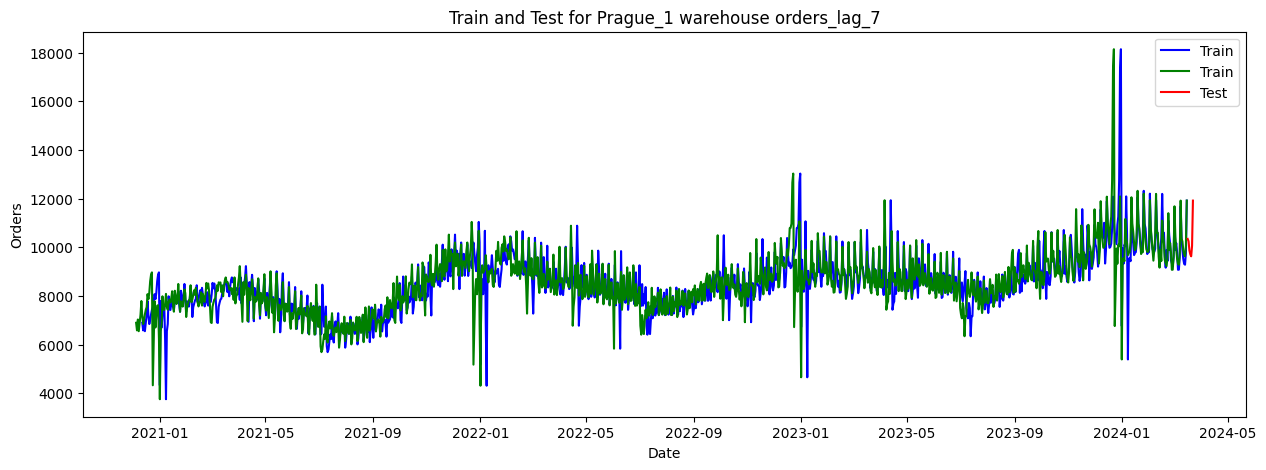

In [38]:
# plot the train and test datasets and visualise them in diferent colors for only column of prague_1 warehouse
feature = f'orders_lag_{LAG_DAYS[0]}'

plt.figure(figsize=(15, 5)) 
datax = train_df[train_df['warehouse'] == 'Prague_1']
datax_test = test_df[test_df['warehouse'] == 'Prague_1']
plt.plot(datax.index, datax[feature], label='Train', color='blue')
plt.plot(datax.index, datax['orders'], label='Train', color='green')
plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')


plt.title(f'Train and Test for Prague_1 warehouse {feature}')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

In [39]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 46)
Test data: (397, 31)


In [40]:
print(train_df.isna().sum())  # Check for Nas

warehouse                     0
orders                        0
holiday                       0
shops_closed                  0
winter_school_holidays        0
school_holidays               0
quarter                       0
year                          0
month                         0
day                           0
day_of_week                   0
day_of_year                   0
is_weekend                    0
days_since_start              0
year_sin                      0
year_cos                      0
month_sin                     0
month_cos                     0
orders_lag_7                 49
orders_lag_28               196
orders_lag_56               392
orders_lag_84               588
orders_lag_168             1176
orders_lag_364             2548
orders_rolling_mean_28        0
orders_rolling_std_28         7
orders_rolling_mean_168       0
orders_rolling_std_168        7
orders_rolling_mean_364       0
orders_rolling_std_364        7
day_of_week_0                 0
day_of_w

In [41]:
"""lag_roll features
"""
LAG_ROLL_FEATURES = []
for feature in numerical_features:
    if 'lag' in feature or 'rolling' in feature:
        LAG_ROLL_FEATURES.append(feature)
print(LAG_ROLL_FEATURES)                                             

['orders_lag_7', 'orders_lag_28', 'orders_lag_56', 'orders_lag_84', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


In [42]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features
}

joblib.dump(scaler_config, 'scaler_config_mt.joblib')

['scaler_config_mt.joblib']

In [43]:
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())        

Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


In [44]:
# check non-continuos date timeline
train_df.index.to_series().diff().value_counts()

date
0 days    6147
1 days    1188
2 days       4
Name: count, dtype: int64

In [45]:
#Standard Scaler:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale_data(X_train, y_train):
    # Initialize the scaler
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Fit the scaler on the numeriacal columns
    X_train_scaled = pd.DataFrame(x_scaler.fit_transform(X_train), columns=X_train.columns)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

    return X_train_scaled, y_train_scaled, x_scaler, y_scaler

In [46]:
train_df.head()

warehouse  orders  holiday  shops_closed  winter_school_holidays  \
date                                                                            
2020-12-05      Brno_1  6447.0        0             0                       0   
2020-12-05  Budapest_1  4623.0        0             0                       0   
2020-12-05    Prague_1  6895.0        0             0                       0   
2020-12-05    Prague_2  4154.0        0             0                       0   
2020-12-05    Prague_3  4091.0        0             0                       0   

            school_holidays  quarter  year  month  day  day_of_week  \
date                                                                  
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   

            day_of_year  is_weekend  days_since_start      year_sin  year_cos  \
date                                                                            
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   

               month_sin  month_cos  orders_lag_7  orders_lag_28  \
date                                                               
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   

            orders_lag_56  orders_lag_84  orders_lag_168  orders_lag_364  \
date                                                                       
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   

            orders_rolling_mean_28  orders_rolling_std_28  \
date                                                        
2020-12-05                  6447.0                    NaN   
2020-12-05                  4623.0                    NaN   
2020-12-05                  6895.0                    NaN   
2020-12-05                  4154.0                    NaN   
2020-12-05                  4091.0                    NaN   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                   6447.0                     NaN   
2020-12-05                   4623.0                     NaN   
2020-12-05                   6895.0                     NaN   
2020-12-05                   4154.0                     NaN   
2020-12-05                   4091.0                     NaN   

            orders_rolling_mean_364  orders_rolling_std_364  day_of_week_0  \
date                                                                         
2020-12-05                   6447.0                     NaN            0.0   
2020-12-05                   4623.0                     NaN            0.0   
2020-12-05                   6895.0                     NaN            0.0   
2020-12-05                   4154.0                     NaN            0.0   
2020-12-05                   40

## Training Loop

In [47]:
def preprocess_data(df, wh):
    train_df,_ = create_lag_features(df, 'orders', LAG_DAYS)
    train_df,_ = create_rolling_features(df, 'orders', ROLLING_WINDOW)
    
    train_df = train_df.fillna(0)
    
    # Drop columns before scaling:
    # Drop the orders column
    X_train = train_df.drop(columns=['orders'])
    y_train = train_df['orders']
    # Drop the warehouse column
    X_train = X_train.drop(columns=['warehouse'])
    # Drop the categorical features (one-hot encoded)
    X_train= X_train.drop(columns=categorical_features)
    # Drop the binary features and store them separately (to be concatenated later)
    X_binary = X_train[binary_features]
    X_train = X_train.drop(columns=binary_features)
        
    X_train_scaled, y_train_scaled, x_scaler, y_scaler = scale_data(X_train, y_train)
    joblib.dump(x_scaler, f'x_scaler_{wh}.joblib')
    joblib.dump(y_scaler, f'y_scaler_{wh}.joblib')
    
    # Concatenate the binary features back to the scaled features
    X_binary = X_binary.reset_index(drop=True)
    X_train_scaled = pd.concat([X_train_scaled, X_binary], axis=1)
    
    
    return X_train_scaled, y_train_scaled, x_scaler, y_scaler

In [48]:
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    # Create sequences for each warehouse
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

In [49]:
def create_model(input_shape, lr=1e-3):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=16, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=1))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr))

    return model

In [50]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss of {warehouse}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [51]:
# Train models for each warehouse
warehouses = train_df['warehouse'].unique()

In [52]:
for warehouse in warehouses:
    print(f"Training model for warehouse: {warehouse}")
    
    warehouse_data = train_df[train_df['warehouse'] == warehouse]
    
    X_train, y_train, x_scaler, y_scaler = preprocess_data(warehouse_data, warehouse)
    print(X_train.head())
    # Create sequences
    X_seq, y_seq = create_sequences(X_train, y_train, time_steps=28)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)
    
    # Create and train model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train, 
        epochs=50, 
        batch_size=32, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    
    plot_loss(history)


Training model for warehouse: Brno_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.577677 -1.211889     1.483102         -1.732070  -0.30871 -2.145151   
1  1.577677 -1.097922     1.492208         -1.729174  -0.30871 -2.145151   
2  1.577677 -0.983955     1.501315         -1.726278  -0.30871 -2.145151   
3  1.577677 -0.869988     1.510421         -1.723382  -0.30871 -2.145151   
4  1.577677 -0.756021     1.519528         -1.720486  -0.30871 -2.145151   

   month_sin  month_cos  orders_lag_7  orders_lag_28  orders_lag_56  \
0  -0.595108   1.577677      -6.56105      -4.939347      -3.910228   
1  -0.595108   1.577677      -6.56105      -4.939347      -3.910228   
2  -0.595108   1.577677      -6.56105      -4.939347      -3.910228   
3  -0.595108   1.577677      -6.56105      -4.939347      -3.910228   
4  -0.595108   1.577677      -6.56105      -4.939347      -3.910228   

   orders_lag_84  orders_lag_168  orders_lag_364  orders_rolling_mean_28  \
0  

KeyboardInterrupt: 

## Inference

In [ ]:
import os

#### MAPE

In [ ]:
# Predict and visualise MAPE for each warehouse with its model and scaler:
mape_scores = []

for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    
    warehouse_data = train_df[train_df['warehouse'] == warehouse]
    
    X_train, y_train, x_scaler, y_scaler = preprocess_data(warehouse_data, warehouse)
    
    # Create sequences
    X_seq, y_seq = create_sequences(X_train, y_train, time_steps=28)
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.h5')
    
    # Predict
    predictions = model.predict(X_seq)
    predictions = y_scaler.inverse_transform(predictions)
    y_seq_unscaled = y_scaler.inverse_transform(y_seq)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_seq_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_seq_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_seq_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error for {warehouse}: {mape:.4f}%')

print("\nMAPE scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean MAPE: {np.mean(mape_scores):.4f}%")   

## Inference:

In [ ]:
# test data preprocessig function without lag, roll features and no "orders" influence:
def inference_preprocess(dataframe, ohsc, cat_col, bin_col):

    # Encode categorical features
    encoded_categorical_features = ohsc.transform(dataframe[cat_col])
    encoded_feature_names = ohsc.get_feature_names_out(cat_col)
    dataframe_encoded = pd.DataFrame(encoded_categorical_features, columns=encoded_feature_names, index=dataframe.index)

    dataframe = pd.concat([dataframe, dataframe_encoded], axis=1)

    dataframe = dataframe.drop(columns=cat_col)
    
    date = dataframe.pop('date')

    dataframe_bin = dataframe[bin_col]
    dataframe = dataframe.drop(columns=bin_col)
    warehouse_col = dataframe.pop('warehouse')
    
    df_trans = x_scaler.transform(dataframe)
        
    dataframe = pd.DataFrame(df_trans, columns=dataframe.columns)
    dataframe_bin = dataframe_bin.reset_index(drop=True)
    dataframe = pd.concat([dataframe, dataframe_bin], axis=1)
    warehouse_col = warehouse_col.reset_index(drop=True)
    dataframe = pd.concat([dataframe, warehouse_col], axis=1)
    dataframe.index = date
    
    return dataframe

In [ ]:
dataframe = pd.read_csv("data/test_proc_mt.csv")
dataframe.head(10)

In [ ]:
# load scaler config:
scaler_config = joblib.load('scaler_config_mt.joblib')
ohsc = joblib.load("scaler_onehot_categorical_mt.joblib")

cat_features = scaler_config['cat_features']
bin_features = scaler_config['bin_features']
    
print(f"cat_features: {cat_features}")
print(f"binary_features: {bin_features}")

In [ ]:
id = dataframe.pop('id')
dataframe.drop(columns=['date.1'], inplace=True)
processed_data = inference_preprocess(dataframe, ohsc, cat_features, bin_features)

In [ ]:
print(len(processed_data.columns))

In [ ]:
# Compare the columns in the original and processed dataframes

X_columns = set(X_train.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("this df has the same columns as the training df.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in train_df:")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in processed_data:")
        print(columns_only_in_processed_data)

In [ ]:
processed_data = processed_data.fillna(0)

In [ ]:
processed_data.head(10)

In [ ]:
processed_data.describe()

In [ ]:
# Load warehouse models and scalers
warehouses = processed_data['warehouse'].unique()
warehouse_models = {}
for wh in warehouses:
    model = tf.keras.models.load_model(f'model_{wh}.h5')
    x_scaler = joblib.load(f'x_scaler_{wh}.joblib')
    y_scaler = joblib.load(f'y_scaler_{wh}.joblib')
    warehouse_models[wh] = {'model': model, 'x_scaler': x_scaler, 'y_scaler': y_scaler}

In [ ]:
def variable_length_predict(data, max_time_steps, feature_columns, warehouse_models):
    predictions = []
    for i in range(len(data)):
        wh = data.iloc[i]['warehouse']
        model = warehouse_models[wh]['model']
        x_scaler = warehouse_models[wh]['x_scaler']
        y_scaler = warehouse_models[wh]['y_scaler']
        
        seq_len = min(max_time_steps, i+1)
        sequence = data[feature_columns].iloc[max(0, i-seq_len+1):i+1]
        
        if len(sequence) < max_time_steps:
            padding = pd.DataFrame([sequence.iloc[0]] * (max_time_steps - len(sequence)), 
                                   columns=sequence.columns)
            sequence = pd.concat([padding, sequence]).reset_index(drop=True)
        
        
        # Scale the sequence
        scale_columns = sequence.columns.difference(bin_features)
        
        scaled_sequence = x_scaler.transform(sequence[scale_columns])
        
        # Reshape the sequence for the model
        model_input = scaled_sequence.reshape(1, max_time_steps, -1)
        
        # Make prediction and rescale
        pred = model.predict(model_input)
        pred_rescaled = y_scaler.inverse_transform(pred)
        predictions.append(pred_rescaled[0][0])
    
    return np.array(predictions)

In [ ]:
# Make predictions
time_steps = 28
feature_columns = [col for col in processed_data.columns if col not in ['id', 'date', 'warehouse']]
predictions = variable_length_predict(processed_data, time_steps, feature_columns, warehouse_models)


In [ ]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'orders': predictions,
    'date': test_df['date'],
    'warehouse': test_df['warehouse']
})

# Save submission CSV
submission_df.to_csv('submission_multi_warehouse.csv', index=False)

In [ ]:
# Plot predictions for each warehouse
for wh in warehouses:
    plt.figure(figsize=(15, 6))
    
    # Plot predicted data
    wh_df = submission_df[submission_df['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', color='red')
    
    # Plot actual data (training data from 2023)
    wh_df_train = train_df_raw[(train_df_raw['warehouse'] == wh) & (train_df_raw['date'].dt.year >= 2023)]
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='black')
    
    plt.title(f'Predicted vs Actual Orders for {wh}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'prediction_plot_{wh}.png')
    plt.close()

print("Predictions complete. Submission file and plots created.")